# World Flight Tracking
This notebook shows all flights currently tracked by the OpenSkyNetwork on a map. It also creates a pie chart showing the percentage of flights by origin country and a table showing the number of planes for each origin country.

In [1]:
# Import Libraries
import requests
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, LabelSet, ColumnDataSource, WMTSTileSource
import numpy as np

# Create Rest API request
url_data='https://opensky-network.org/api/states/all'
response=requests.get(url_data).json()

# Load to pandas dataframe
col_name=['icao24','callsign','origin_country','time_position','last_contact','long','lat','baro_altitude','on_ground','velocity',
          'true_track','vertical_rate','sensors','geo_altitude','squawk','spi','position_source']
flight_df=pd.DataFrame(response['states'])
flight_df=flight_df.loc[:,0:16]
flight_df.columns=col_name
flight_df=flight_df.fillna('No Data')

# Function to convert WGS84 to Web Mercator
def wgs84_web_mercator_point(lon, lat):
    k = 6378137
    x = lon * (k * np.pi / 180.0)
    y = np.log(np.tan((90 + lat) * np.pi / 360.0)) * k
    return x, y

# Convert flight data to Web Mercator
def wgs84_to_web_mercator(df, lon="long", lat="lat"):
    k = 6378137
    df["x"] = df[lon] * (k * np.pi / 180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi / 360.0)) * k
    return df

# Convert 'long' and 'lat' to numeric
flight_df['long'] = pd.to_numeric(flight_df['long'], errors='coerce')
flight_df['lat'] = pd.to_numeric(flight_df['lat'], errors='coerce')

flight_df = wgs84_to_web_mercator(flight_df)

# Define Bokeh plot
p = figure(x_axis_type='mercator', y_axis_type='mercator', sizing_mode='scale_width', height=300)

# Define the tile source using OpenStreetMap
tile_provider = WMTSTileSource(
    url="https://a.tile.openstreetmap.org/{Z}/{X}/{Y}.png",
    attribution=(
        'Map tiles by <a href="http://openstreetmap.org">OpenStreetMap</a>, '
        'under <a href="http://creativecommons.org/licenses/by-sa/2.0">CC BY SA</a>.'
    )
)

# Add OpenStreetMap tiles
p.add_tile(tile_provider, level='image')

# Create ColumnDataSource for flight data
flight_source = ColumnDataSource(flight_df)

# Plot flight data points
p.scatter('x', 'y', source=flight_source, fill_color='red', hover_color='yellow',
          size=10, fill_alpha=0.8, line_width=0, marker="circle")

# Add hover tool
my_hover = HoverTool()
my_hover.tooltips = [('Call sign', '@callsign'), ('Origin Country', '@origin_country'),
                     ('Velocity (m/s)', '@velocity'), ('Altitude (m)', '@baro_altitude')]
p.add_tools(my_hover)

# Add labels
labels = LabelSet(x='x', y='y', text='callsign', level='glyph',
                  x_offset=5, y_offset=5, source=flight_source,
                  background_fill_color='white', text_font_size="8pt")
p.add_layout(labels)

# Show the plot
show(p)

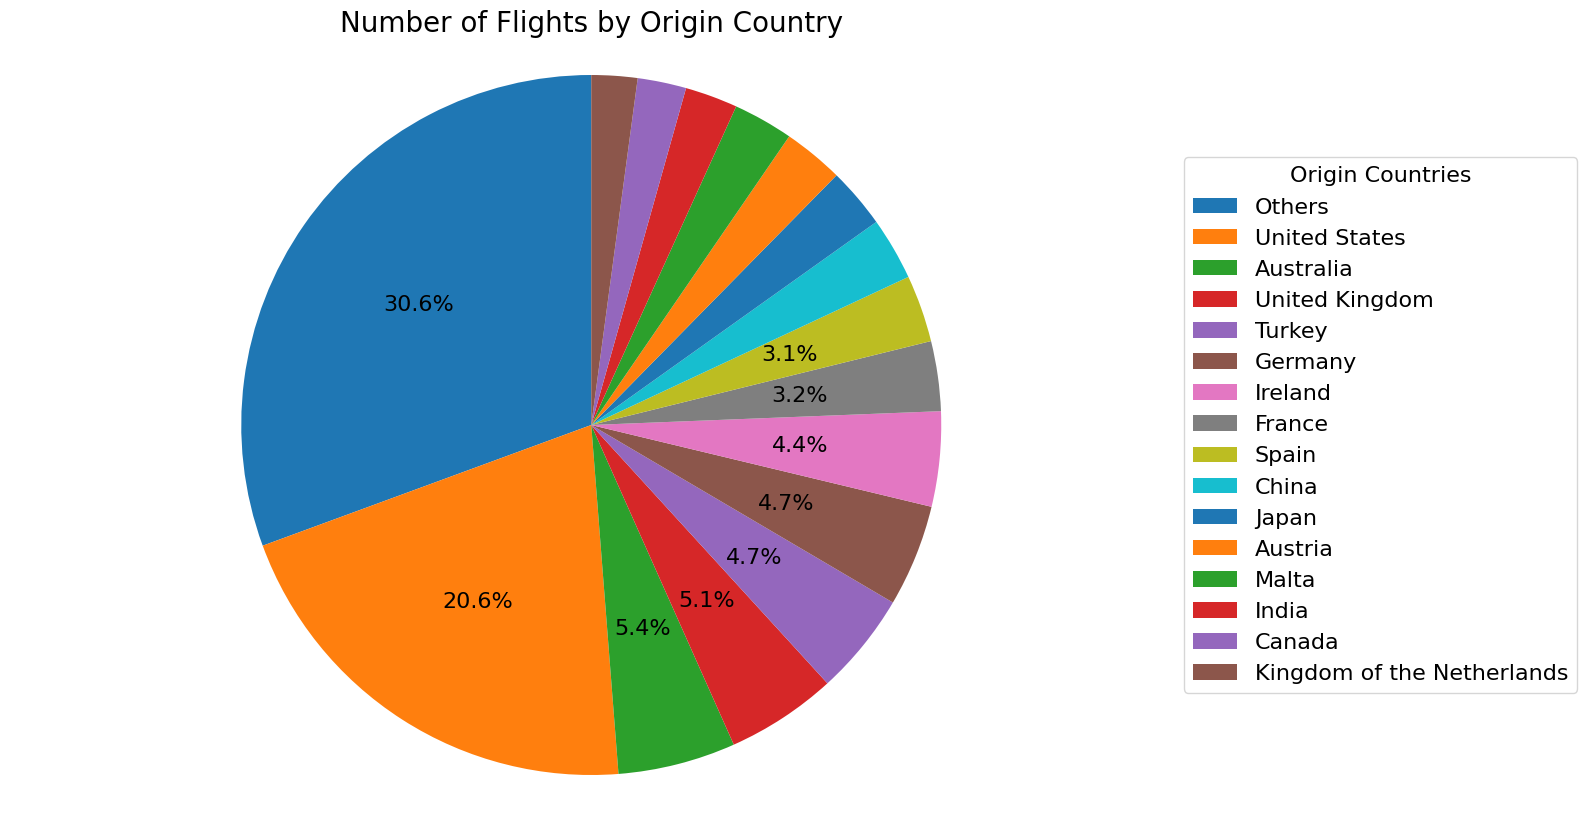

In [17]:
import matplotlib.pyplot as plt

# Calculate the percentage of the total for each country
country_percent = flight_df['origin_country'].value_counts(normalize=True) * 100

# Create a new series where countries with more than 2% of the total are kept, and all other countries are replaced with "Others"
country_grouped = flight_df['origin_country'].replace(country_percent[country_percent < 2].index, 'Others')

# Count the number of flights in this new series
country_counts = country_grouped.value_counts()

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '%1.1f%%' % pct if pct > 3 else ''
    return my_format

# Create a pie chart
fig, ax = plt.subplots(figsize=(15, 10))
ax.pie(country_counts, autopct=autopct_format(country_counts), startangle=90, textprops={'fontsize': 16})

# Add a legend
ax.legend(country_counts.index, title="Origin Countries", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=16, title_fontsize=16)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Add a title
plt.title('Number of Flights by Origin Country', fontsize=20)

plt.show()

In [19]:
# Count the number of planes for each origin country
country_plane_counts = flight_df['origin_country'].value_counts()

# Convert the series to a dataframe for better visualization
country_plane_counts_df = country_plane_counts.reset_index()
country_plane_counts_df.columns = ['Origin Country', 'Number of Planes']

# Show the dataframe
country_plane_counts_df

,Origin Country,Number of Planes
0,United States,1139
1,Australia,300
2,United Kingdom,282
3,Turkey,262
4,Germany,260
...,...,...
99,Syrian Arab Republic,1
100,Nepal,1
101,Rwanda,1
102,Afghanistan,1
